In [1]:
import numpy as np
import pandas as pd
from tqdm import trange 
import time
import os

In [2]:
df = pd.read_csv('group_call_HMS.csv')
df.head()

,call_start_day,call_start_time,call_end_day,call_end_time,hashed
0,1,09:14:58.558,1,09:41:30.200,967393e81d99ce8e577ee130b7ce8e4fd45e3e9cecb560...
1,17,11:05:05.176,17,13:07:42.515,02181a0c962f34f019bc9d5b582fb0ec79b1441f96aa4d...
2,20,02:18:43.172,20,02:28:58.177,86022904c5cf72a54978479c94041f4256d6c3c2a1f71c...
3,22,09:22:01.936,22,09:47:40.192,aafb40d212fe18ff4eafb82fdcf3b53f2161cb3ce59de4...
4,26,06:29:21.182,26,06:50:55.004,c87c2fad141edf323f3787335b54be22945a02fe052448...


### 피쳐설명

- Call start day : 전화 시작 날짜
- Call end day : 전화 끝 날짜

- Call start time : 전화 시작 시간
- Call end time : 전화 시작 시간

- hashed : 그룹 전화 참여원 목록 

### 로드맵

- day, time 변수를 이용하여 총 통화시간 구하기
- hashed 에 묶여있는 참여원 각각 기준으로 총 통화시간과 횟수 구하기
- 참여원 목록을 통해 누가 누구와 통화하였는지 Communication mapping 

## Processing

### 1. 총 통화시간 구하기 -> real_call_time(list)

In [5]:
def change_to_second(x):
    hour = int(x[:2])
    minute = int(x[3:5])
    second = float(x[6:])
    return 3600*hour + 60*minute + second

In [8]:
## 시간관련
start_time = (i for i in df['call_start_time'])
end_time = (i for i in df['call_end_time'])
start_day = (i for i in df['call_start_day'])
end_day = (i for i in df['call_end_day'])

real_call_time=[]

for i in trange(len(df)):
    temp_start_time = next(start_time)
    temp_end_time = next(end_time)
    second_start = change_to_second(temp_start_time)
    second_end = change_to_second(temp_end_time)
    real_call_time.append(3600*24*(next(end_day)-next(start_day))+ second_end - second_start)
 

100%|██████████| 6962341/6962341 [00:32<00:00, 212635.14it/s]


In [10]:
df['call_time'] = real_call_time
del df['call_start_day']
del df['call_end_day']
del df['call_start_time']
del df['call_end_time']
df.head()

,hashed,call_time
0,967393e81d99ce8e577ee130b7ce8e4fd45e3e9cecb560...,1591.642
1,02181a0c962f34f019bc9d5b582fb0ec79b1441f96aa4d...,7357.339
2,86022904c5cf72a54978479c94041f4256d6c3c2a1f71c...,615.005
3,aafb40d212fe18ff4eafb82fdcf3b53f2161cb3ce59de4...,1538.256
4,c87c2fad141edf323f3787335b54be22945a02fe052448...,1293.822


## 2. hashed 안의 각각 hash 별로 총통화시간, 총통화횟수 구하기  -> new_data1

In [12]:
sum_time =[{},{}]
temp_hash = (i for i in df['hashed'])
temp_call_time = (i for i in df['call_time'])


# next로 주소값 불러오기 
for i in trange(len(df)):
    call_time = next(temp_call_time) # 첫번째 그룹의 call time
    t_h = next(temp_hash) # 첫번째 그룹
    split_hash = t_h.split(',') # [a,b,c,d]
    
    
    temp_split_hash = (user for user in split_hash) #  제너레이터 [a,b,c,d]
    
    for j in range(len(split_hash)):
        user_id = next(temp_split_hash) # 첫번째 그룹의 사람한명
        
        if user_id in sum_time[0].keys():
            sum_time[0][user_id] += call_time
            
        else:
            sum_time[0][user_id] = call_time
            
        if user_id in sum_time[1].keys():
            sum_time[1][user_id] += 1
            
        else:
            sum_time[1][user_id] = 1
        
            
        

100%|██████████| 6962341/6962341 [01:22<00:00, 84499.80it/s]


In [20]:
new_data1 = pd.DataFrame(list(sum_time[0].items()),columns=['ID','TIME'])
new_data2 = pd.DataFrame(list(sum_time[1].items()),columns=['ID','COUNT'])

In [21]:
new_data1 = pd.merge(new_data1,new_data2,on='ID')
new_data1.head()

,ID,TIME,COUNT
0,967393e81d99ce8e577ee130b7ce8e4fd45e3e9cecb560...,354761.827,129
1,a0b6ecbec654b18fe36ebe6230e25a653fb12125733583...,78372.345,110
2,3193ab18168bcadbcb8342c06c4a35fa0d6e58d9619fe8...,448051.062,479
3,02181a0c962f34f019bc9d5b582fb0ec79b1441f96aa4d...,855458.296,267
4,769f00750d87fa59f8b6083aae62fb394e165101796fe5...,774491.333,290


## 3. hash 별 통화시간, 통화건수에 대한 자료분석


In [23]:
display(new_data1.describe())

,TIME,COUNT
count,2.681480e+05,268148.000000
mean,1.986305e+05,127.855818
std,4.243052e+05,257.100419
min,0.000000e+00,1.000000
25%,2.132517e+03,3.000000
50%,2.607863e+04,24.000000
75%,2.077883e+05,143.000000
max,5.138354e+07,31498.000000


In [25]:
new_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268148 entries, 0 to 268147
Data columns (total 3 columns):
ID       268148 non-null object
TIME     268148 non-null float64
COUNT    268148 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.2+ MB


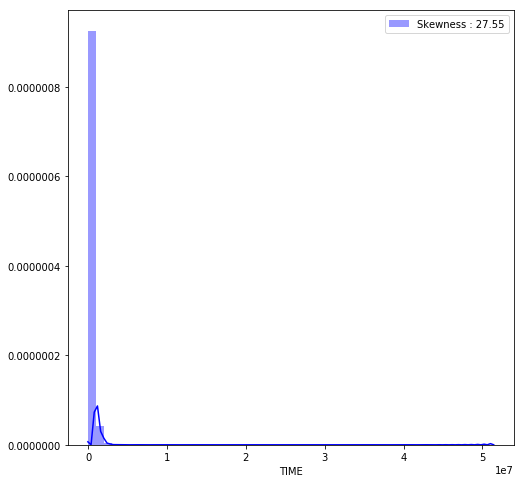

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(new_data1['TIME'], color='b', label='Skewness : {:.2f}'.format(new_data1['TIME'].skew()), ax=ax)
g = g.legend(loc='best')

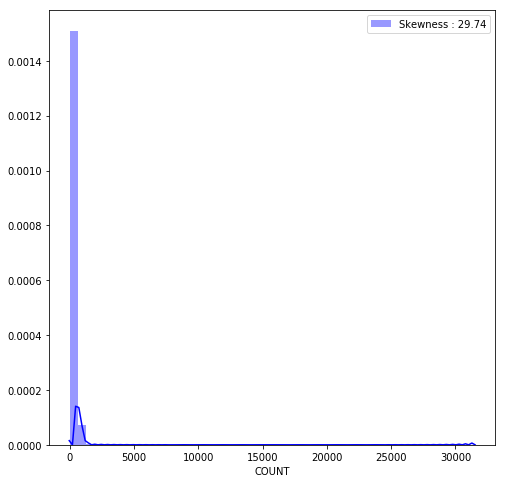

In [32]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(new_data1['COUNT'], color='b', label='Skewness : {:.2f}'.format(new_data1['COUNT'].skew()), ax=ax)
g = g.legend(loc='best')

In [50]:
## 
at_least_Two_call = new_data1['COUNT']<3
at_least_Two_call.sum()

#268148-203307 = 64841 <- 이 인원이 전화건수가 3건 미만 

64841

### 매우 Skewed 되어 있다. 

### 여기서 유용한 정보는 '핵인싸' 찾기로 정하자 -> COUNT 기준 상위 20명 

In [51]:
new_data1.sort_values(by=['COUNT'],inplace=True,ascending=False)
new_data1.head() 

,ID,TIME,COUNT
113147,a183c2b789eb249afbb85c17f7b45886ab5e9a36bc3792...,5.138354e+07,31498
113148,9d6c5c34e7443b4ca86d47c05bee7116fb032e89a1c178...,4.759796e+07,29335
113146,e7c75ecc843536c63aa2e11cd2c3b58eac270428ab53d5...,4.784716e+07,28971
113180,8dafd5d19cfcd044348a6a7ec91745a1293bde2fedda59...,4.475763e+07,28808
113178,3e48bcfcf37498565ec7639fe71feb05b7db71583f6141...,3.990107e+07,26119


In [53]:
insider = new_data1.iloc[:50]